# Classifying Investing Advice: A Look Into The World of A Bogle Head

## Problem Statement

Investing for the people is a non profit organization started by a former employee of John Bogle, the founder of Vanguard. John Bogle had a simple investing style recommending people buy mutual funds or ETFs that try to mimic the entire stock market. When buying these funds, they pay special attention to fees, and only invest in funds with low fees and expenses. Taxes are also a huge consideration. To maximize tax efficiency, investment vehicles like 401ks and IRAs are the preferred mediums. 

Investing for the people is looking to spread John Bogles investing advice to more people especially those who are new to investing. The executives at Investing for the people have asked their data science time to build a model that uses natuarl language processing to identify websites and message boards that share John Bogle's investing advice. Once a message or website has been identified as including the core principles of Bogle investing, Investing for the people will add it to it's approved list of financial websites. 

The team has been asked to test their model on Reddit where there is no dearth of investing advice. The executives want to see the model perform well before funding the roll out of the program. They want to see the model can differentiate between traditional investing advice, which can be found on r/Investing and the advice of John Bogle which can be found on r/Bogleheads. An accuracy rate of 85% has been set as the goal for the target for the team to meet. 

## Executive Summary

Initially the team assumed it would be easy to distinguish between the two as in general r/Bogleheads focuses more on index funds or exchange traded funds (ETFs). These types of funds are essentially a basket of individual stocks that are selected to match or track the components of financial market index. Subscribers of r/Bogleheads usually reference the stock ticket symbols associated with these funds (VTI, VOO, VTSAX). We observed these symbols when looking at top occurences of words during the EDA process. Retirement Accounts such as IRA, Roth IRA and 401k also jumped out when looking at r/Bogleheads. With both of fund categories and retiremnt categories being distinguishing features of r/Bogleheads we were confident we cold acheive the target accuarcy rate of 85%. 

Three models were selected for production, they included a Logistic Regression Classification model and two Naive Bayes Models (Multinomial & Gaussian). The thought process here was to a have at least one model for interpreation and one for prediction. We also wanted to compare two Naive Bayes models to see which one performed better. We would include the transformers CountVectorizer and TfidfVectorizer on each of the models to generate more results as we wanted to see which combinations would work best. Including pipelines allowed us to apply a number of transformers and a final estimator. We then used GridSearchCV to test a number of different values and combinations of hyper-parameters. This would help us identify the best possible score of our models. 

Since the data we pulled from reddit using reddit's API we created a baseline model that was essentially 50%. We were confident our models would outperform this baseline score. Initially scoring results were in the 80%-85% and continued to climb as we adjusted the parameters of the model. However, we weren't hitting the desired goal of 85% accuracy as we were observing too many incorrect predictions. We attributed this to many of the same words and investing terms in both subreddits. There was a lot of overlap and if posts were short and only included one or two features that had a high coefficient from the other subreddit it would result in a misclassification. 

Our approach was to create simple models and increase the complexity as we went while tuning the parameters. This resulted in us observing an inscrease in model performance. However, we also started to observe higher variance in our models which caused us to scale back on complexity to find an ideal bias variance tradeoff. 

## Table of Contents


##### Data Collection
##### Libraries
##### Importing Data
##### Data Cleaning & Preprocessing
##### Model Preparation
##### Modeling
##### Model Selection
##### Model Evaluation
##### Conclusion
##### Recommendations
##### References

## Data Collection

The data was collected from r/Bogleheads and r/Investing using the Reddit API. 

Because r/Ivesting is a considerably larger subreddit with over a million subscribers we only needed to pull data on two months of data to acheive our desired result of 1000 posts. r/Bogleheads is a much smaller and less popular subreddit and we had to pull data from a greater scope date. 

## Libraries 

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import TransformerMixin
import nltk
import re
import string
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import roc_auc_score

## Importing Data

In [72]:
df_reddit = pd.read_csv('./data/df_reddit.csv')

In [73]:
df_reddit.shape

(2029, 9)

In [74]:
df_reddit.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,"Free market capitalism, I’m Gen Z and honestly...",[removed],investing,1584573611,KellyCriterionHedged,13,0,True,2020-03-18
1,Tell me why I shouldn’t purchase a substantial...,[deleted],investing,1584573629,[deleted],10,1,True,2020-03-18
2,Can my 401k retirement account trigger a wash ...,Hypothetical scenario:\n\nI am looking to sell...,investing,1584573685,philosophytautology,9,0,True,2020-03-18
3,GILD.. The DD is in the link... FDA message to...,\n\nThe DD is in the link.. Why the fuck shou...,investing,1584573694,TawALittlePuttyTat,2,0,True,2020-03-18
4,Good time to invest?,Do y'all think there will be a raise in the ma...,investing,1584573941,rcmiddle,10,0,True,2020-03-18


In [75]:
df_reddit.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
2024,Late 30's with 14 month old twins...,"Hi there, we are seeing a financial advisor en...",Bogleheads,1532267202,goldy740,4,12,True,2018-07-22
2025,Moving money from American Funds. I need help ...,[removed],Bogleheads,1532308550,smithfoam,0,1,True,2018-07-22
2026,$10k to invest - Need guidance,Hi - I had been depositing $100 every month in...,Bogleheads,1532365928,suzukiaquarian1,10,4,True,2018-07-23
2027,401k Advice,My plan right now is to go 100% stocks: 60% US...,Bogleheads,1532370877,neonbeanbag,5,5,True,2018-07-23
2028,401k Vanguard allocation advice (newbie),Apologies in advance for my very newbie questi...,Bogleheads,1532548204,aegyo_bae,9,6,True,2018-07-25


## Data Cleaning & Preprocessing 

In [76]:
df_reddit.isnull().sum()

title            0
selftext        83
subreddit        0
created_utc      0
author           0
num_comments     0
score            0
is_self          0
timestamp        0
dtype: int64

In [77]:
#fill null values with empty strings. Will add selftext and text columns together
df_reddit.selftext.fillna(value='', inplace=True)

In [78]:
#Transform target variable into a binary category r/Investing will be 1 and r/Bogleheads will be 0. 
df_reddit['target']= df_reddit['subreddit'].map({'investing': 1, 'Bogleheads':0})

In [79]:
#drop column subreddit now that we have created a new column 'target' which will be the y variable. 
df_reddit.drop('subreddit', axis = 1, inplace = True)

In [80]:
df_reddit.shape

(2029, 9)

In [81]:
#drop columns that will not be used in our model. The most pertinent information for our goal of predicting subreddits
#comes from columns title and selftext 
df_reddit.drop(columns =['created_utc', 'author', 'num_comments', 'score', 'is_self',
                         'timestamp'], axis = 1, inplace = True)

In [82]:
df_reddit.shape

(2029, 3)

In [83]:
#check value counts of the subreddits. We have balanced classes.
df_reddit['target'].value_counts(normalize = True)

0    0.507146
1    0.492854
Name: target, dtype: float64

In [84]:
#Check for duplicates in our subreddit posts. 
df_reddit.duplicated().sum()

8

Duplicate values seem to be related to posts in r/Investing where a user says they have X amount of money and they would like advice on how to invest it. One of the rules of this subreddit is these posts should be directed to r/PersonalFinance as opposed to r/Investing because they are very common and not in line with the investing strategies and approaches of the subreddit. We also observe this with Cryptocurrency advice which r/Investing moderators asked be redircted to a subreddit that has more of a focus on this asset class. 

In [85]:
#Review Duplicates to see what information they may contain
df_reddit[df_reddit.duplicated(['title'])] [['selftext', 'title']].sort_values(by='title')

,selftext,title
497,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
550,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
696,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
856,"If your question is ""I have $10,000, what do I...",Daily Advice Thread - All basic help or advice...
226,How to calculate stock profit i tought i knew ...,Help
229,How to calculate stock profit i tought i knew ...,Help
671,I just got my fidelity account set up and I do...,Investing
1611,"Hi guys,\n\nI recently opened a Roth account (...",Investing
562,[removed],Pi Network Cryptocurrency
619,[removed],Pi Network Cryptocurrency


In [86]:
df_reddit.drop_duplicates(inplace = True)

In [87]:
df_reddit.shape

(2021, 3)

In [88]:
df_reddit.duplicated().sum()

0

Worldcloud is not data science but were produced as an image for my slideshow. However, they initially gave me an
idea of what words would appear with the most frequency in each subreddit. 

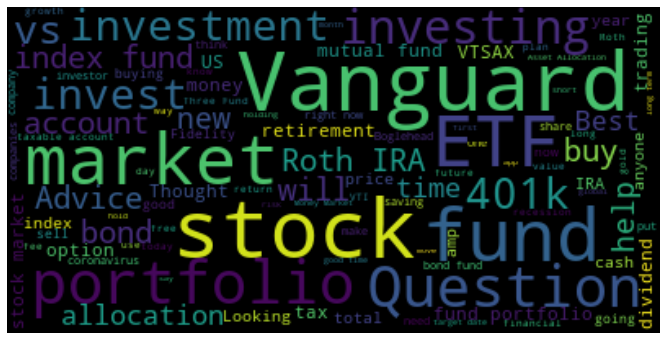

In [89]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(' '.join(df_reddit['title']))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Starting to identify overlap of features in the two subreddits. This is where we begin to worry about our 85% 
accuracy goal. 

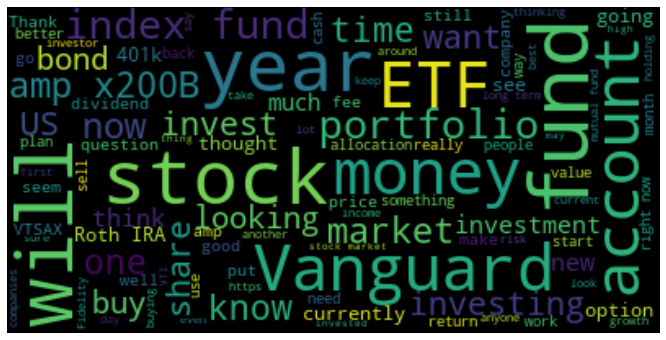

In [90]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(' '.join(df_reddit['selftext']))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [91]:
#merge title and selftext columns together to create features column. 
df_reddit['features'] = df_reddit['title'] + ' ' + df_reddit['selftext']

In [92]:
df_reddit.head()

,title,selftext,target,features
0,"Free market capitalism, I’m Gen Z and honestly...",[removed],1,"Free market capitalism, I’m Gen Z and honestly..."
1,Tell me why I shouldn’t purchase a substantial...,[deleted],1,Tell me why I shouldn’t purchase a substantial...
2,Can my 401k retirement account trigger a wash ...,Hypothetical scenario:\n\nI am looking to sell...,1,Can my 401k retirement account trigger a wash ...
3,GILD.. The DD is in the link... FDA message to...,\n\nThe DD is in the link.. Why the fuck shou...,1,GILD.. The DD is in the link... FDA message to...
4,Good time to invest?,Do y'all think there will be a raise in the ma...,1,Good time to invest? Do y'all think there will...


### Text Cleaning

Create function to clean text. Function makes all words lowercase, strips away punctuation and hyperlinks to 
websites. Decided it would be beneficial to keep the numbers 4,0 and 1 as a popular retirement account is a 401K
and we anticipated this to be one of the top words in our features list. Was not concerned about other numbers as most posts included numbers related to amount of money someone was investing (10k, 5k, etc.)

RegEX Tokenizer

In [93]:

def clean_str(string):
    string = string.lower()
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    string = re.sub(url_pattern, ' ', string)
    string = re.sub(r"\n", "", string)    
    string = re.sub(r"\r", "", string) 
    string = re.sub(r"[0-9]+", "", string)
    string = re.sub(r'[^\w\s]','', string)    
    
    return string.strip()

In [94]:
#use .map to apply function to dataframe
df_reddit['features'] = df_reddit['features'].map(clean_str)

In [95]:
#check results of text cleaning function
df_reddit.head()

,title,selftext,target,features
0,"Free market capitalism, I’m Gen Z and honestly...",[removed],1,free market capitalism im gen z and honestly i...
1,Tell me why I shouldn’t purchase a substantial...,[deleted],1,tell me why i shouldnt purchase a substantial ...
2,Can my 401k retirement account trigger a wash ...,Hypothetical scenario:\n\nI am looking to sell...,1,can my k retirement account trigger a wash sal...
3,GILD.. The DD is in the link... FDA message to...,\n\nThe DD is in the link.. Why the fuck shou...,1,gild the dd is in the link fda message tomorro...
4,Good time to invest?,Do y'all think there will be a raise in the ma...,1,good time to invest do yall think there will b...


In [96]:
df_reddit.drop(columns =['title', 'selftext'], axis = 1, inplace = True)

In [97]:
df_reddit.head(5)

,target,features
0,1,free market capitalism im gen z and honestly i...
1,1,tell me why i shouldnt purchase a substantial ...
2,1,can my k retirement account trigger a wash sal...
3,1,gild the dd is in the link fda message tomorro...
4,1,good time to invest do yall think there will b...


### Lemmaitizer

Lemmatize words to get only the base word, this may help reduce noise in our model. A word like investing or invested will become invest.

In [98]:
#Instantiate WordNetLemmatizer to get base words of words in features list
lemmatizer = WordNetLemmatizer()

def func(text):                       
    return [lemmatizer.lemmatize(word) for word in text.split()]
                        
df_reddit['features'].map(func)

0       [free, market, capitalism, im, gen, z, and, ho...
1       [tell, me, why, i, shouldnt, purchase, a, subs...
2       [can, my, k, retirement, account, trigger, a, ...
3       [gild, the, dd, is, in, the, link, fda, messag...
4       [good, time, to, invest, do, yall, think, ther...
                              ...                        
2024    [late, s, with, month, old, twin, hi, there, w...
2025    [moving, money, from, american, fund, i, need,...
2026    [k, to, invest, need, guidance, hi, i, had, be...
2027    [k, advice, my, plan, right, now, is, to, go, ...
2028    [k, vanguard, allocation, advice, newbie, apol...
Name: features, Length: 2021, dtype: object

### Initial Word Counts for EDA

In [99]:
#use basic countvectorizer to get the top 20 words from the features column 
cv_test = CountVectorizer(stop_words = 'english')
words = cv_test.fit_transform(df_reddit['features'])

cv_test = pd.DataFrame(words.todense(), columns=cv_test.get_feature_names())

In [100]:
top_total_words = cv_test.sum().sort_values().tail(20)

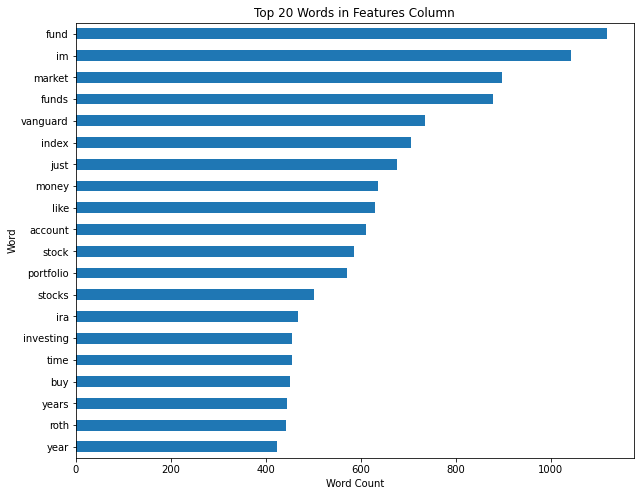

In [101]:
plt.figure(figsize=(10,8))


top_total_words.plot(kind='barh')
plt.title('Top 20 Words in Features Column')
plt.xlabel('Word Count')
plt.ylabel('Word');

Visualizing the most frequent words that occured in both subreddits returns many common investing terms (fund, market, index, money, stock, portfolio). The stopword 'I'm' has made it through due to lack of an apostrophe by commentors. This will be added to a customized stopword list along with like and just. 00 has also occured because we removed all numbers but 0,1 & 4 (to return 401K). This is linked to retiremtnt target date funds. (VFIFX 2030, 2035, etc) The years represent the desired retirement year of an investor. 

### Word Counts by Subreddit

First we will use countvectorizer to get a count of most frequently used words in each subreddit

In [102]:
# Instantiate CountVectorizer. At this point in EDA we will use this to get top word counts from each of the subreddits.
cv = CountVectorizer(analyzer = 'word',
                             tokenizer= None ,
                             preprocessor = None ,
                             stop_words = 'english',
                             max_features = 1000,
                             ngram_range = (1,2))


In [103]:
#create variable for target 1, r/investing for word count analysis 
investing = df_reddit[df_reddit['target'] == 1]['features']

In [104]:
# fit_transform() does two things: First, it fits the model and learns the vocabulary; second, it 
#transforms our training datainto feature vectors. The input to fit_transform should be a list of strings.

# Fit CountVectorizer to target data investing 
investing_words = cv.fit_transform(investing)

In [105]:
#Transform r/investing data based on the fit CountVectorizer 
investing_words = cv.transform(investing)

In [106]:
# Create a DataFrame with our words.
top_investing_words = pd.DataFrame(investing_words.todense(), columns = cv.get_feature_names() )

In [107]:
#return top r/investing terms 
top_investing_words.sum().sort_values(ascending = False).head()

market    415
im        341
stock     333
like      282
stocks    270
dtype: int64

In [108]:
#create variable for target 0, r/Bogleheads for word count analysis 
bogleheads = df_reddit[df_reddit['target'] == 0]['features']

In [109]:
bolge_words = cv.fit_transform(bogleheads)

In [110]:
bolge_words = cv.transform(bogleheads)

In [111]:
top_bogle_words = pd.DataFrame(bolge_words.todense(), columns = cv.get_feature_names() )

In [112]:
top_bogle_words.sum().sort_values(ascending = False).head()

fund        997
funds       736
im          701
vanguard    696
index       617
dtype: int64

In [113]:
top_20_bogle = top_bogle_words.sum().sort_values().tail(20)

In [114]:
top_20_investing = top_investing_words.sum().sort_values().tail(20)

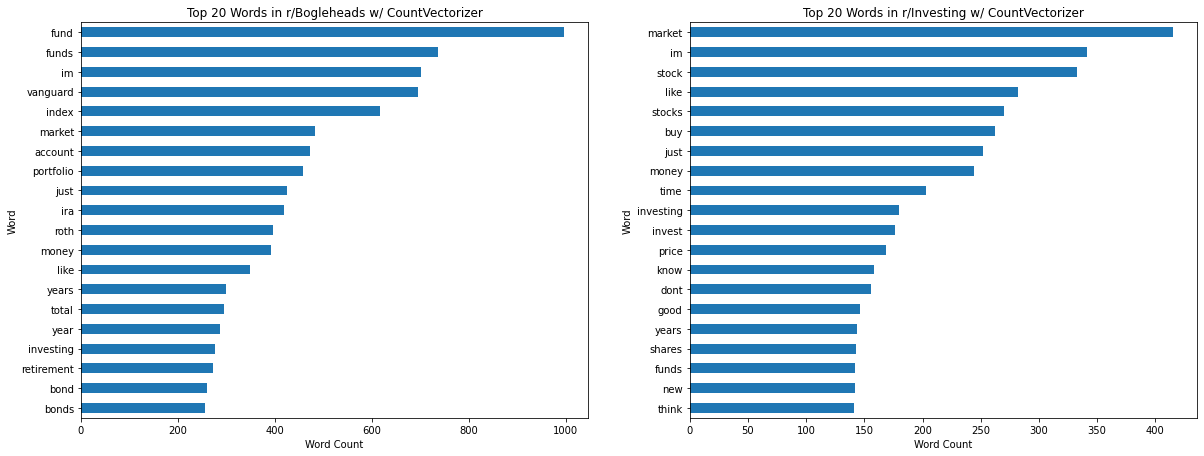

In [115]:
#plt size
plt.figure(figsize=(20,16))

#create first sublot for r/Bogleheads
plt.subplot(2,2,1)
top_20_bogle.plot(kind='barh')
plt.title('Top 20 Words in r/Bogleheads w/ CountVectorizer')
plt.xlabel('Word Count')
plt.ylabel('Word')

#create second subpolot for r/Investing
plt.subplot(2,2,2)
top_20_investing.plot(kind='barh')
plt.title('Top 20 Words in r/Investing w/ CountVectorizer')
plt.xlabel('Word Count')
plt.ylabel('Word');


In [116]:
#TF-IDF is a score that tells us which words are important to one document, relative to all other documents. 
#Words that occur often in one document but don't occur in many documents contain more predictive power.

In [117]:
#Instantiate TFIDFVectorizer 
tvec = TfidfVectorizer(analyzer = "word", 
                     stop_words = 'english', 
                     max_features = 1000, 
                     ngram_range = (1, 2))

In [118]:
investing_words_tvec = tvec.fit_transform(investing)

In [119]:

investing_words_tvec = tvec.transform(investing)

In [120]:
investing_words_tvec = pd.DataFrame(investing_words_tvec.todense(), columns = tvec.get_feature_names() )

In [121]:
investing_words_tvec.sum().sort_values(ascending = False).head()

removed    42.044990
market     31.704605
stocks     31.286133
stock      30.242848
im         29.136360
dtype: float64

In [122]:
top_tfidf_investing = investing_words_tvec.sum().sort_values().tail(20)

In [123]:
top_tfidf_bogle = top_bogle_words.sum().sort_values().tail(20)

In [124]:
bolge_words_tvec = tvec.fit_transform(bogleheads)

In [125]:
bolge_words_tvec = tvec.transform(bogleheads)

In [126]:
top_bogle_words_tvec = pd.DataFrame(bolge_words_tvec.todense(), columns = tvec.get_feature_names() )

In [127]:
top_bogle_words_tvec.sum().sort_values(ascending = False).head(5)

fund        53.651886
vanguard    45.108600
funds       43.672890
im          40.356475
index       38.683761
dtype: float64

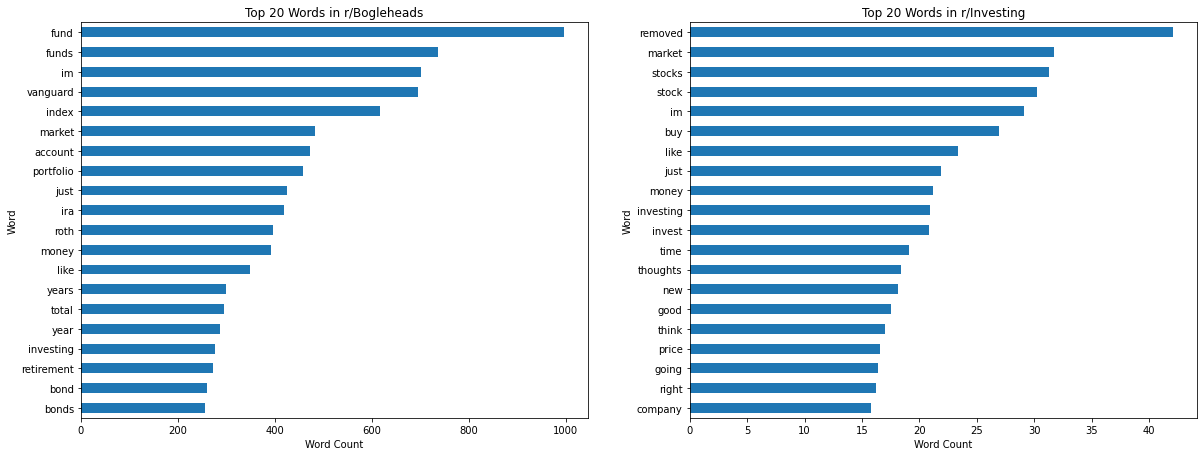

In [128]:
plt.figure(figsize=(20,16))

plt.subplot(2,2,1)
top_tfidf_bogle.plot(kind='barh')
plt.title('Top 20 Words in r/Bogleheads')
plt.xlabel('Word Count')
plt.ylabel('Word')

plt.subplot(2,2,2)
top_tfidf_investing.plot(kind='barh')
plt.title('Top 20 Words in r/Investing')
plt.xlabel('Word Count')
plt.ylabel('Word');

After using TFIDFVectorizer to do a count of words in our features column for each subreddit we start to see terms more associated with r/Boglehead style of investing move to the top. Vanguard takes second place after fund, Vanguard is the company that Jack Bogle founded and is a leading provider in index funds and ETFs. We do not see this word appear in the top 20 in r/investing. We also see more words associoted with index funds and retirement accounts higher on the list (index, ira, roth, 401k). We also observe a specific Vanguard fund VTSAX on the list which is a total market index fund. We also observe no 2 gram words appear anywhere in the top twenty for either sub reddit. The first two gram word that appears in r/Bogleheads is index fund at position 35. No 2 gram words appear in the top 50 word count for r/investing. 

## Stopwords

After reviewing counts of frequently occuring words in the subreddits we need to add words that we believe may reduce model performance. The words 'ive', 'dont' and'im' should have been removed in pre-processing but were not because the commentor did not include an apostrophe in their spelling. 'Removed' is a frequently occuring word in r/Investing but only because that is the word that is seen after a post is taken down by either the original poster or a moderator. 

In [131]:
#create custom stopwords list by creating a list and using .extend to add to the built in stopwords. 
stopwords = nltk.corpus.stopwords.words('english')
reddit_stop_words = ['ive', '00', 'im', 'just', 'know', 'like', 'does', 'dont', 'like', 'removed',]
stopwords.extend(reddit_stop_words)
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Model Preparation 

In [132]:
#create X and y values
y = df_reddit['target']
X = df_reddit['features']

In [133]:
#return value count of our values 
y.value_counts(normalize = True)

0    0.509154
1    0.490846
Name: target, dtype: float64

### Test Train Split

In [134]:
#train test split, stratify y and include a random_state for reproducibility of training and testing data. 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state = 42)

## Modeling

Model preparation included creating a baseline model in order to have an initial result from our data set to compare the other models we will be using. Before modeling we perfomed a train/test split on our dataset. 
We will be create a pipeline using either CountVectorizer or TfidfVectorizer as a transformer. The models that will be used include Logistic Regression, Gaussian Naive Bayes, and Multinomial Naive Bayes. A gridsearch will be performed on each model in attempt to identify the best parameters. Models will be assessed on their accuracy score on testing data. 

### Baseline Model

The classes are essentially even so our baseline model is almost exactly 50%. This model will be used in the evaluation process to compare the performance of all of the other models with will be using.

In [135]:
y_train.value_counts(normalize = True)

0    0.508911
1    0.491089
Name: target, dtype: float64

#### Logistic Regression w/ CountVectorizer 

In [141]:
#Instantiate pipeline
pipe_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])


#Define gird of parameters to GridSearch over
pipe_params1 = {'cvec__max_features': [500, 1000], #max number of features are model will use in evaluation
              'cvec__stop_words': [stopwords],
                'cvec__min_df': [5],
               'cvec__max_df': [.75],
               'cvec__ngram_range': [(1,1), (1,2)]} # include 1 and 2 gram words

#gridSearch over pipeline with given grid of parametrs 
gs1 = GridSearchCV(pipe_cv, 
                 pipe_params1,
                 cv=5)# 5-fold cross-validation.

In [142]:
#Fit Model 
gs1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [143]:

print(gs1.score(X_train, y_train))
print(gs1.score(X_test, y_test))
print(cross_val_score(lr, X, y, cv = 5).mean())
gs1.best_params_

0.9775577557755776
0.8003952569169961


NameError: name 'lr' is not defined

This model score extremely high at 98.3% on the training data. However, the testing score was only 81.6%. A difference of 13% makes us think that this model is overfit. The hyperparameters were 'tuned'(stopwords were removed, max_df & min_df were removed) but we saw no significant difference in our results. It will be interesting to see how the tokenizer TfidfVectorizer compares to this Logistic Regression model. 

The model is selecting two gram features demonstrating that it can handle more complexity. 

#### Logistic Regression w/ TFIDFVectorizer

In [ ]:
#Logistic Regression Model w/ TFIDFVectorizer
pipe_tf = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'liblinear'))
])


pipe_params_tf = {'tvec__max_features': [500, 1000, 1500], #max features 
              'tvec__stop_words': [stopwords, None], #customized stopwords list and no stopwords 
               'tvec__ngram_range': [(1,1), (1,2)]}

gs_tf = GridSearchCV(pipe_tf, 
                     pipe_params_tf, 
                     cv=5)

In [ ]:
#Fit Model 
gs_tf.fit(X_train, y_train)

In [ ]:
#max features 1,000 n_gram range (1,2) 
print(gs_tf.best_score_) 
print(gs_tf.score(X_test, y_test)) 
gs_tf.best_params_

The Logistic Regression model + TfidfVectorizer doesn't perform nearly as well on the training data as the LR model + Countvectorizer. However, we observe much less variance in this model. When tuning we removed max and min df and observed a significant decrease in variance in the model. In an attempt to find the sweet spot of trade off between high variance and high bias we decided to leave these parameters out. 

We also observe this model using 2 gram features as it is able to pick up more complex phrases. 


The score is still well above our baseline model but the scoring is probably not as high as we need to achieve the desired accuaracy rate of 85%.

## GaussianNB model

In [ ]:
#Referenced from dsi_11-NYC FAQ
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [ ]:
cvec_gnb = [
    ("cvec", CountVectorizer()),
    ("dense", DenseTransformer()),
    ("gauss", GaussianNB())
]

cvec_paramsgnb = {
    'cvec__max_features': [500, 1000 , 1500],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None, 'english', stopwords]}


pipegnb = Pipeline(cvec_gnb)

cvec_guasNB = GridSearchCV(pipegnb, cvec_paramsgnb, cv = 5)

In [ ]:
cvec_guasNB.fit(X_train, y_train)

In [ ]:
print(cvec_guasNB.score(X_train, y_train))
print(cvec_guasNB.score(X_test, y_test))
cvec_guasNB.best_params_

In the Gaussian model we see an increase in training score in comparison to the LR TfidfVectorizer model but a decrease in the testing score. We again removed max and min df as it was causing too much variance in the model. 

We also observe it is only taking into account one gram words, demonstrating it is not as likely to pick up on more complex phrases or combinations of words. 

It also returns None as the best parameter for stop words which we did not anticipate. 

In [ ]:
tvec_gnb = [
    ("tvec", TfidfVectorizer()),
    ("dense", DenseTransformer()),
    ("gauss", GaussianNB())
]

tvec_paramsgnb = {
    'tvec__max_features': [500, 1000 , 1500],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english', stopwords]}


pipegnb1 = Pipeline(tvec_gnb)

tvec_guasNB = GridSearchCV(pipegnb1, tvec_paramsgnb, cv = 5)

In [ ]:
tvec_guasNB.fit(X_train, y_train)

In [ ]:
print(tvec_guasNB.score(X_train, y_train))
print(tvec_guasNB.score(X_test, y_test))
tvec_guasNB.best_params_

In the Gaussian + TfidfVectorizer model we see an increase in score in realtion to the previous model (Gaussian + CoutVectorizer) but observe the similar amount of variance in our model. 

The model does show 2 gram words as the best pararmeter for n gram range, which suggest it can identify more complexity in our word features. 

Again we observe None as the best parameter for stopwords. 

#### Multinomial Naive Bayes w/ CountVectorizer 

In [ ]:
multinomialnb = [
    ("cvec", CountVectorizer()),
    ("mult", MultinomialNB())
]
mb_params = {
    'cvec__max_features': [500, 1000, 1500],
    'cvec__min_df': [5],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None, 'english', stopwords] 
}


pipemnb = Pipeline(multinomialnb )

cvec_mnb = GridSearchCV(pipemnb, mb_params, cv = 5)

In [ ]:
cvec_mnb.fit(X_train, y_train)

In [ ]:
print(cvec_mnb.score(X_train, y_train))
print(cvec_mnb.score(X_test, y_test))
cvec_mnb.best_params_

The Multinomial Naive Bayes + CountVectorizer  model continues the pattern we have observed thus far. Training scores in the mid to high eighties (with the exception of the LR + Countvectorizer model) but has a lower training score. We have included min and max df again as the score was higher and the variance was lower in the model as there was not as great of difference between the training and testing score. 

Model identifies the custom stopwords list as the best parameter. 

In [ ]:
multinomialtf = [
    ("tvec", TfidfVectorizer()),
    ("mult", MultinomialNB())
]
multitf_params = {
    'tvec__max_features': [500, 1000, 1500],
    'tvec__min_df': [5],
    'tvec__max_df': [.75],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [None, 'english', stopwords] 
}


pipemntf = Pipeline(multinomialtf )

tvec_mnb = GridSearchCV(pipemntf, multitf_params, cv = 5)

In [ ]:
tvec_mnb.fit(X_train, y_train)

In [ ]:
print(tvec_mnb.score(X_train, y_train))
print(tvec_mnb.score(X_test, y_test))
tvec_mnb.best_params_

## Model Selection

Multinomial Naive Bayes model + TfidfVectorizer scores slightly better than our MNB + TfidfVectorizer. The hyperparameters opitmized here are the english or standard stopwords and 1 gram words. Overall it seems models using TfidfVectorizer performed better in respect to training socre. We observed higher scores (with the exception of one outlier, LR+CV model). However, we observed the same amout of variance in each of the models using TfidfVectorizer.

We will be looking at accuracy scores to select the best performing model. However, we want to evalute the Logistic Regression model for interprability by evaluating the coefficients to see the importance of words or combination of words to our target variable

## Model Evaluation

##### Logistic Regression w/ CountVectorizer

In [ ]:
y_pred = gs1.predict(X_test)

In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns=['Predicted r/Bogleheads', 'Predicted r/Investing'],
            index=['Actual r/Bogleheads', 'Actual r/Investing'])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#Accuracy
print(round((tp+tn)/(tp+fp+tn+fn),4))
#Misclassification
print(round((fp+fn)/(tp+fp+tn+fn),4))
#Precision
print(round(tp/(tp+fp),4))
#Specificity
print(round(tn/(tn+fp),4))

#### Logistic Regression w/ TFIDFVectorizer

In [ ]:
#get X_test predicted values
y_pred1 = gs_tf.predict(X_test)

In [ ]:
#Create confusion matrix 
pd.DataFrame(confusion_matrix(y_test, y_pred1),
            columns=['Predicted r/Bogleheads', 'Predicted r/Investing'],
            index=['Actual r/Bogleheads', 'Actual r/Investing'])

In [ ]:
#Calculate scores 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred1).ravel()
#Accuracy
print(round((tp+tn)/(tp1+fp1+tn1+fn1),4))
#Misclassification
print(round((fp+fn)/(tp+fp+tn+fn),4))
#Sensitivity 
print(round(tp/(tp+fp),4))
#Specificity
print(round(tn/(tn+fp),4))

#### Gaussian Naive Bayes w/CountVectorizer

In [ ]:
#calculate predicted values from the best perfoming model Gaussian Naive Bayes using TFIDFVectorizer 
y_pred2 = cvec_guasNB.predict(X_test)


In [ ]:
#Create confusion matrix to visualize false positves, true positives, false negatives and true negatives
pd.DataFrame(confusion_matrix(y_test, y_pred2),
            columns=['Predicted r/Bogleheads', 'Predicted r/Investing'],
            index=['Actual r/Bogleheads', 'Actual r/Investing'])

In [ ]:
#Calculate classification metrics
#referenced from https://datascience.stackexchange.com/questions/28493/confusion-matrix-get-items-fp-fn-tp-tn-python
tn, fp, fn, tp = confusion_matrix(y_test, y_pred2).ravel()
#Accuracy
print(round((tp+tn)/(tp+fp+tn+fn),4))
#Misclassification
print(round((fp+fn)/(tp+fp+tn+fn),4))
#Precision
print(round(tp/(tp+fp),4))
#Specificity
print(round(tn/(tn+fp),4))

In [ ]:
y_pred3 = tvec_guasNB.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred3).ravel()
pd.DataFrame(confusion_matrix(y_test, y_pred3),
            columns=['Predicted r/Bogleheads', 'Predicted r/Investing'],
            index=['Actual r/Bogleheads', 'Actual r/Investing'])

In [ ]:
#Accuracy
print(round((tp+tn)/(tp+fp+tn+fn),4))
#Misclassification
print(round((fp+fn)/(tp+fp+tn+fn),4))
#Precision
print(round(tp/(tp+fp),4))
#Specificity
print(round(tn/(tn+fp),4))

In [ ]:
y_pred4 = cvec_mnb.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred4).ravel()
pd.DataFrame(confusion_matrix(y_test, y_pred4),
            columns=['Predicted r/Bogleheads', 'Predicted r/Investing'],
            index=['Actual r/Bogleheads', 'Actual r/Investing'])

In [ ]:
#Accuracy
print(round((tp+tn)/(tp+fp+tn+fn),4))
#Misclassification
print(round((fp+fn)/(tp+fp+tn+fn),4))
#Precision
print(round(tp/(tp+fp),4))
#Specificity
print(round(tn/(tn+fp),4))

In [ ]:
y_pred5 = tvec_mnb.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred5).ravel()
pd.DataFrame(confusion_matrix(y_test, y_pred4),
            columns=['Predicted r/Bogleheads', 'Predicted r/Investing'],
            index=['Actual r/Bogleheads', 'Actual r/Investing'])

In [ ]:
#Accuracy
print(round((tp+tn)/(tp+fp+tn+fn),4))
#Misclassification
print(round((fp+fn)/(tp+fp+tn+fn),4))
#Precision
print(round(tp/(tp+fp),4))
#Specificity
print(round(tn/(tn+fp),4))

#### Selecting a model

The best performing model was the Logistic Regression + TfidfVectorizer model. It achieved the highest accuracy score of 82.4%. However, it only perfoms slightly better than the rest of the models as the lowest score of the six modesl was 78.6% and all accuracy scores but one were above 80%. All of the models perfomed much better than the baseline model as we had anticipated. This model does standout because it had the lowest variance with training and testing scores being 84% & 82.4%. A spread between these scores of less than 2% was better than all other models in comparison which averaged about 7% and included one outlier with a difference in training and testing scores of 16%.

It is somewhat surprising that the Logistic Regression model performed the best. We had anticipated one of the Naive Bayes models to perform better as one of the strengths of that type of model is text classification. We were also surprised to see that some models optimized for the custom stopwords, the standard 'english' stopwords, and even no stopwords at all. This seemed to have little affect on the performance of the model. However, we did see some consistency when using Tfidfvectorizer as this usually selected for 2 gram words showing it could identify more complex word combinations. 

## Coefficinets 

The best performing model Logistic Regression + CountVectorizer is an interpretable model and we can evaluate the coefficients from the model to understand what words or combinations of words are when predicting which subreddit these words are associated with. During our EDA process there were certain words that we believed had a stronger relation to each subreddit. The coefficients of our model will now quantify the relation of those words to each subreddit.

In [ ]:
word_coefs = pd.DataFrame(gs_tf.best_estimator_.named_steps['lr'].coef_.T,
                         index = gs_tf.best_estimator_.named_steps["tvec"].get_feature_names()).sort_values(0)

In [ ]:
bogle_coefs = pd.DataFrame(word_coefs[:20])
investing_coefs = pd.DataFrame(word_coefs[-20:].sort_values(0, ascending = False))

In [ ]:
investing_coefs.columns=['Coef']

In [ ]:
investing_coefs

#### r/Investing Coefficients

The highest coefficients observed in the r/Investing are words that are related to general investment advice and strategy and focus more on individual stock picking. Thhe top word is trading which we do not observe in the top 20 coefficients of the r/Bogelhead list. We observe other general investing words like company and stock which would indicate people discussing indivdual stocks as opposed to index funds or ETFs which are very popular in r/Bogleheads. Coronavirus also makes an appearence on this list as this has had a drastic impact recently on the stock market and is greatly affecting the stock market in the short term. Bogleheads are more focused on long term growth and may not be concerned about the short term affects of the coronavirus on the market. 

In [ ]:
bogle_coefs.columns=['Coef']

In [ ]:
bogle_coefs = np.abs(bogle_coefs['Coef'])

In [ ]:
bogle_coefs = pd.DataFrame(bogle_coefs)

In [ ]:
#calculated absolute value of the words 
bogle_coefs

#### r/Bogleheads Coefficients

The coefficients of the top words in r/Bogleheads show greater correalation than the words in r/Investing. The highest coefficent for r/Bogleheads is Vanguard. The other top words here relate to index funds and this list also includes the word bogleheads itself, as this is what subscribers of r/Boglehead refer to themselves as. This list is consisent with what we had anticipated. Based on the syle of investing r/Boglehead follows the words with the highest coefficients relate to index funds. We observe the name of two specific index funds, VTI and VTSAX which are both total market funds and are very popular with passive investors. Other words in the list include words related to retirment accounts (ira, roth, retirement).

#### Misclassifications 

In [ ]:
#Create dataframe to look at misclassifications 
df_pred = pd.DataFrame({

    'X_test': X_test,
    'y_test': y_test,
    'y_pred': y_pred
})

misclassifications = df_pred[df_pred['y_test'] != df_pred['y_pred']]

In [ ]:
#evaluate misclassifcations to gain a better understanding as to why these posts/titles were not predicted correctly
print(misclassifications)

In [ ]:
#identify misclassified posts for additoinal analysis
for post in df_pred[(df_pred.y_test - df_pred.y_pred) == 1]['X_test']:
    print(post)

#### Overlap of Words

 Due to there being so much overlap in investing terms it makes sense that misclassification can happen. There are many investing terms like 'index', 'fund', 'investing', 'market', 'stocks', etc. that appear so frequently between the two subreddits misclassifciaton is bound to happen. There are a few unique words to r/Bogleheads that appear with greater frequency but there will always be posts that don't include these words. The unique words from r/Bogleheads like 'vti', 'vtsax', 'vym' are products that are sold by Vanguard but it is not uncommon for the average investor to hold some of these index funds, in fact they are quite common in the investing world. If these words which we could consider r/Boglehead words appear in r/investing misclassification is more likely to happen. 

misclassified as r/investing 

"what is the purpose of dbc in all weather portfolio historical performance for dbc which i understand isnt everything is quite lackluster  i just dont fundamentally understand what value the commodity allocation has to this overall portfolio"

This is a short post and doesn't offer too many features for the model to take into consideration. It also it doesn't have many features that have a high coefficient to r/Bogleheads. Because the similarities in the two subreddits misclassification is bound to happen at some points, especially on shorter posts. 


Misclassified as r/Bogleheads

“Vti voo voog i want to buy all is that a bad idea im young and all stocks”


This posts references a number of Vanguard products that have high coefficients to r/Bogleheads. However, it is not uncommon for the average investor to hold these funds in their portfolio. These misclassificaiton posts tend to result from overlap in the two subreddits. They are both foucsed on investing advice so we are going to observe the use of many of the same terms and even financial products. 

## Conclusion 

Unfortunately we did not achieve the goal of 85% accuracy for our model. In hindsight it was naive to think r/Bogleheads offered investing advice that was that much different than r/Investing. Investing can be complicated and there are many differnent terms and investment products that could differentiate investing styles but for the most part investors are going to simliar asset classes (stocks, bonds, commodities) to invest their money. Many investment products (VTI, VTSAX) are extremely popular for the average investor and not just bought by a niche group of investors who follow specific investing advice. 

In preprocessing we took the necessary steps to remove frequently occuring words by identifying these words and adding them to the standard stop words list. This was in attempt to to reduce their affect on the model. However, when looking at the model performance we did not observe consistency in the model using this as the ideal parameter. Sometimes the model used the stopword list other times it did not. This did not seem to have as big of an impact we had originally thought. 

The best performing model was the Logistic Regression Model + TfidfVectorizer which achieved an accuracy score of 85%. This model was observed to be low variance as it had less than a 2% difference between the training score and testing score. However, this score was close but not good enough and we will have to review our workflow from the beginning to see if any improvements can be made that will achieve a better result. 


## Recommendations

The reduced scope date when pulling data from r/Investing most likely helped in our performance. This is due to a higher occurence of words on short term market activity. Coronavirus appered high in the coefficients for r/investing because this has been an ongoing topic and it is greatly affecting the stock market. If we had equal scope dates we most likely we observe a decrease in the occurence of this word dating back to last year. Do work toward a better performing model we should take scope date of data into consideration. We did not need to attempt to have balanced classes as this is not how data exists in the real world. 

Create more models, a limited approach was taking this time and we were unable to compare the models we used to other models such as KNN, Random Forest, or Decision Tree. This limited our results and we may have had a better performing model if we used something else. 



## References

Investopdiea, James Chenn, Jan,2016 https://www.investopedia.com/terms/j/john_bogle.asp